## Error model
The purpose of this notebook is to establish an error model for the backscatter measurement in the BioLector. The model predicts the estimated $\mu_{BS}(\hat{X})$ and $\sigma_{BS}(\hat{X})$ as parameters of student-t-distributed measurement errors. The PDF of this distribution can be used to calculate the likelihood of a measurement $BS_{obs}$ given the assumption $X=\hat{X}=\phi(\theta)$.

In order to calculate the PDF, the distribution of the two parameters $\mu_{BS}(\hat{X})$ and $\sigma_{BS}(\hat{X})$ must be fitted from calibration data which is demonstrated in the following sections.

In [12]:
import abc
from matplotlib.lines import Line2D
from matplotlib import pyplot
import numpy
import pandas
import pathlib
import scipy
import scipy.odr
import scipy.stats
import bletl

import calibr8
import murefi

### Technical calibration of raw data with the *bletl* package
For the error model, an NTU turbidity standard was measured at different concentrations with a fixed volume of 800 µl in the BioLector. The shaking frequency was increased by 100 rpm every hour, resulting in a total range of 500 to 1500 rpm. <br/>

In [3]:
filepath = pathlib.Path('Data', 'LaHe_ShakerSteps_20181108_160720.csv')

bldata = bletl.parse(filepath)

### Filter the data measured at each shaking frequency
Since the shaking frequency is not included in the model, only data measured at a fixed shaking frequency can be used. The data is therefore filtered by the shaking switchpoint and processed into a dictionary. <br/>
The backscatter signal was measured with a gain of 10 and a gain of 20. For reasons of comparison to other calibration data, only measurements with a gain of 10 are further processed.

In [5]:
bldata.comments

,time,user_comment,sys_comment
0,0.00494,"Open Cover, SWITCH SETPOINT:Freq.=500,",None
1,1.00716,SWITCH SETPOINT:Freq.=600,None
2,2.00579,SWITCH SETPOINT:Freq.=700,None
3,3.03909,SWITCH SETPOINT:Freq.=800,None
4,4.00586,SWITCH SETPOINT:Freq.=900,None
5,5.02254,SWITCH SETPOINT:Freq.=1000,None
6,6.00620,SWITCH SETPOINT:Freq.=1100,None
7,7.00633,SWITCH SETPOINT:Freq.=1200,None
8,8.05669,SWITCH SETPOINT:Freq.=1300,None
9,9.00542,SWITCH SETPOINT:Freq.=1400,None


In [7]:
#Filter the shaking switchpoints from the comments
frequencies = ['500', '600', '700', '800', '900', '1000', '1100', '1200', '1300', '1400', '1500']
shaking_switchpoints = [
    float(bldata.comments.time[0:-1].loc[bldata.comments.user_comment.str.contains(f'={frequence}')])
    for frequence in frequencies
]
shaking_switchpoints.append(bldata.comments.time.values[-1])

#Create a dataframe with the periods of each shaking frequency
shaking_periods = pandas.DataFrame(columns=['shaking_frequency', 'started_at', 'ended_at'])
shaking_periods['shaking_frequency'] = frequencies
shaking_periods['started_at']=shaking_switchpoints[:-1]
shaking_periods['ended_at']=shaking_switchpoints[1:]
shaking_periods

,shaking_frequency,started_at,ended_at
0,500,0.00494,1.00716
1,600,1.00716,2.00579
2,700,2.00579,3.03909
3,800,3.03909,4.00586
4,900,4.00586,5.02254
5,1000,5.02254,6.00620
6,1100,6.00620,7.00633
7,1200,7.00633,8.05669
8,1300,8.05669,9.00542
9,1400,9.00542,10.04027


In [9]:
#For reasons of comparison
gain = 'BS10'

# Create a dictionary containing the data for each shaking frequency
data_by_frequence = {}
for i in range(len(shaking_switchpoints)-1):
    all_times = bldata[gain].time['A01']
    start = shaking_periods['started_at']
    end = shaking_periods['ended_at']
    timepoints = bldata[gain].time.loc[(all_times >= start[i]) & (all_times < end[i])]
    measurements = bldata[gain].value.loc[(all_times >= start[i]) & (all_times < end[i])]  
    data_by_frequence[frequencies[i]] = (timepoints, measurements)

### Assemble data necessary for the fit
Now that the data is separated by shaking frequency, data with a fixed shaking frequency of 1000 rpm is chosen for the parameter fit. Moreover, the mean value of measurements of the same NTU concentration is calculated to reduce the amount of data. <br/>
The NTU standard values are saved as x_observed.  <br/>
The corresponding means of backscatter measurements are saved as y_observed. 


In [10]:
wells = ['A', 'B', 'C', 'D', 'E', 'F']
wellnumbers = ['01', '02', '03', '04', '05', '06', '07', '08']
key = '1000'

# An array with the dilutions of the turbidity standard in NTU is created
dilutions = numpy.array([4000,3000,400,300,40,30,4,3])[numpy.newaxis,:]
for r in range(5):
    last = dilutions[-1,:]
    dilutions = numpy.vstack((dilutions, last / 2))

# x_observed corresponds to the NTU dilutions,y_observed to the measured backscatter
x_observed = numpy.array([
    dilutions[i][j]
    for i, well in enumerate(wells)
    for j, wellnumber in enumerate(wellnumbers)
])
y_observed = numpy.array([
   numpy.mean(data_by_frequence[key][1][f'{well}{wellnumber}'])
    for i, well in enumerate(wells)
    for j, wellnumber in enumerate(wellnumbers)
])

#Standard deviations of y_observed

y_std = numpy.array([
    numpy.std(data_by_frequence[key][1][f'{well}{wellnumber}'])
    for i, well in enumerate(wells)
    for j, wellnumber in enumerate(wellnumbers)
])
        

### Datframe of fitting data
To provide a better overview of the data, it is assembled into a Pandas Dataframe

In [11]:
df_data_fit = pandas.DataFrame()
df_data_fit['NTU'] = x_observed
df_data_fit['BS'] = y_observed
df_data_fit['BS_std'] = y_std
df_data_fit

,NTU,BS,BS_std
0,4000.00000,232.615373,1.242606
1,3000.00000,227.555903,3.945145
2,400.00000,35.266615,0.269141
3,300.00000,28.238437,0.223892
4,40.00000,6.849042,0.179614
5,30.00000,6.055884,0.250171
6,4.00000,4.230912,0.277771
7,3.00000,3.812347,0.263888
8,2000.00000,127.223144,0.616316
9,1500.00000,103.449408,1.230773


### Parameter fitting for  $\mu_{BS}(\hat{X})$ and $\sigma_{BS}(\hat{X})$

In order to estimate the distibutions of the parameters $\mu_{BS}(\hat{X})$ and $\sigma_{BS}(\hat{X})$, suitable models need to be assumed for both. 

For the expected mean value $\mu_{BS}(\hat{X})$, a logistic model can be assumed because a saturation effect of the sensor can be observed for both low and high backscatter signals. The following parametrisation is used:

$$f(x)=2\ I_y - L + \frac{2 \cdot (L - I_y)}{1 + e^{\ 4s \ (x - I_x)}}$$

| Parameter | Interpretation
| --- | --- |
| $I_x$ | concentration at the inflection point |
| $I_y$ | readout at the inflection point |
| $L$ | readout in saturation |
| $s$ | slope at inflection point |


However, we observe that the inflection point of a logistic function describing the backscatter does not lie symmetrically between the low-backscatter and the high-backscatter plateau, but is shifted towards lower backscatter values. Therefore, the logistic model is assumed to be valid for the logarithmic observed backscatter $ln(BS_{obs})$ in dependency of the logarithmic true backscatter $ln(BS_{true})=ln(X)$. Accordingly, the prediction $\hat{X}$ is transformed to the logarithmic space before being passed to the logistic function and the logistic parameters $I_x$, $I_y$, $L_{max}$ and $s$ must be interpreted in log-spaces:

$$f(ln(x))=2\ I_y - L + \frac{2 \cdot (L - I_y)}{1 + e^{\ 4s \ (ln(x) - I_x)}}$$

Moreover, a linear correlation between the turbidity standard, the cell dry weight and the true backscatter is assumed. Consequently, the fit can first be performed with the NTU standard dilutions. Later, after analyzing the NTU-based calibration data, we will revisit this assumption.

To describe the expected standard deviation of measurement errors as a function of true biomass (or backscatter), we use a 1st order polynomial:

$$\sigma_{BS}(\hat{X})=\theta_0 + \theta_1 \cdot \hat{X}$$

Finally, the parameters for $\mu_{BS}(\hat{X})$ and $\sigma_{BS}(\hat{X})$ are fitted simultaneously by a maximum likelihood estimation with $\Theta_L$ containing both the parameters of the logistic and the polynomial function:

$$\underset{\Theta}{\arg\max}\ \mathcal{L}(BS_{obs} \mid \hat{X}, \Theta_L)$$



### Implementation as class 'ErrorModel'
To implement the model in Python, a class named **ErrorModel** was created which provides an abstract structure. This structure is useful for all kind of error models and thus enables that future error models (e.g. for assay calibrations) can be used similarly. 

The parent class **ErrorModel** comprises the functions *error_model*, *evaluate_loglikelihood*, *loglikelihood* and *fit*. The function *error_model* specifies which model is assumed for the error distribution. The function *loglikelihood* calculates the sum of log likelihoods for observed values given the predictions and parameters from *error_model*. To fit the model, the optimization algorithm in the *fit* function iteratively calls loglikelihood with different parameter vectors. *evaluate_loglikelihood* is a convenience function that wraps around *loglikelihood* and uses previously determined model parameters to calculate the likelihood. Except for *evaluate_loglikelihood*, all functions need to be implemented in the inheriting classes.

In the subclass **BiomassErrorModel**, we assume a logistic model for $\mu_{BS}(\hat{X})$ and a first degree polynomial model for $\sigma_{BS}(\hat{X})$ as explained before. The function *error_model* calculates these parameters with the help of the functions *logistic* and *polynomial*. The sum of log likelihoods of $BS_{obs}$ given the predictions $\hat{X}$ is calculated in *loglikelihood*. The *fit* function is implemented as an optimization procedure using scipy.optimize.minimize. After the fit is performed, the fitted parameters (*theta_fitted*) are stored internally, such that the object can later be queried for predictions via the *evaluate_loglikelihood* function. 

In [13]:
class BiomassErrorModel(calibr8.ErrorModel):
    def logistic(self, y_hat, theta_log):
        """Log-log logistic model of the expected measurement outcomes, given a true independent variable.
        
        Arguments:
            y_hat (array): realizations of the independent variable
            theta_log (array): parameters of the log-log logistic model
                I_x: inflection point (ln(x))
                I_y: inflection point (ln(y))
                Lmax: maximum value in log sapce
                s: log-log slope
        """
        # IMPORTANT: Outside of this function, it is irrelevant that the correlation is modeled in log-log space.
   
        # Since the logistic function is assumed for logarithmic backscatter in dependency of logarithmic NTU, 
        # the interpretation of (I_x, I_y, Lmax and s) is in terms of log-space.
        
        I_x, I_y, Lmax = theta_log[:3]
        s = theta_log[3:]
        
        # For the same reason, y_hat (the x-axis) must be transformed into log-space.
        y_hat = numpy.log(y_hat)
        
        y_val = 2 * I_y - Lmax + (2 * (Lmax - I_y)) / (1 + numpy.exp(-4*s * (y_hat - I_x)))
        
        # The logistic model predicts a log-transformed y_val, but outside of this
        # function, the non-log value is expected.        
        return numpy.exp(y_val)
    
    def polynomial(self, y_hat, theta_pol):
        # Numpy's polynomial function wants to get the highest degree first
        return numpy.polyval(theta_pol[::-1], y_hat)
    
    def error_model(self, y_hat, theta):
        mu = self.logistic(y_hat, theta[:4])
        sigma = self.polynomial(y_hat,theta[4:])
        return mu, sigma
        
    def loglikelihood(self, y, y_hat, theta):
        mu, sigma = self.error_model(y_hat, theta)
        # using t-distributed error in the non-transformed space
        likelihoods = scipy.stats.t.pdf(x=y, loc=mu, scale=sigma, df=1)
        loglikelihoods = numpy.log(likelihoods)
        ll = numpy.sum(loglikelihoods)
        return ll
    
    def fit(self, y, y_hat, theta_guessed, bounds):
        def sum_negative_loglikelihood(theta):
            return(-self.loglikelihood(y, y_hat, theta))
        fit = scipy.optimize.minimize(sum_negative_loglikelihood, theta_guessed, bounds=bounds)
        self.theta_fitted = fit.x
        return fit

### Arranging the inital guesses in a Pandas dataframe and perform the fit

In [15]:
name_guess_low_up = [
    # name        guess            lower_bound     upper_bound
    ('ln(I_x)',   numpy.log(400),  numpy.log(10),  numpy.log(5000)),
    ('ln(I_y)',   numpy.log(500),  numpy.log(10),  numpy.log(1000)),
    ('ln(L_max)', numpy.log(1000), numpy.log(500), numpy.log(10000)),
    ('slope',     1.2,             0.01,           10),
    ('sigma_0',   10,              0.1,            20),
    ('sigma_1',   0.1,             0,              0.1),
]


df_fit = pandas.DataFrame(columns=['name', 'guess', 'bounds', 'fit', 'hit_bounds'])
df_fit['name'] = [p for p, g, l, u in name_guess_low_up]
df_fit['guess'] = [g for p, g, l, u in name_guess_low_up]
df_fit['bounds'] = [(l,u) for p, g, l, u in name_guess_low_up]
df_fit['fit'] = None
df_fit['hit_bounds'] = None

biomass_error_model = BiomassErrorModel(independent_key='X', dependent_key='BS')
result = biomass_error_model.fit(y_observed, x_observed, df_fit['guess'], bounds=df_fit['bounds'])

print(result)

df_fit['fit'] = result.x
lower_bounds = [u for l, u in df_fit['bounds']]
upper_bounds = [u for l, u in df_fit['bounds']]
df_fit['hit_bounds'] = numpy.logical_or(
    numpy.isclose(result.x, lower_bounds, rtol=0.01),
    numpy.isclose(result.x, upper_bounds, rtol=0.01)
)
df_fit

      fun: 76.73222389139448
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.92983407e-03, -1.07775122e-02,  4.21309494e+00,  2.45165666e-02,
        7.24753590e-04, -4.68958206e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1442
      nit: 107
   status: 0
  success: True
        x: array([6.26690677e+00, 3.79236729e+00, 6.21460810e+00, 1.74207696e-01,
       3.00557298e-01, 1.05005714e-03])


,name,guess,bounds,fit,hit_bounds
0,ln(I_x),5.991465,"(2.302585092994046, 8.517193191416238)",6.266907,False
1,ln(I_y),6.214608,"(2.302585092994046, 6.907755278982137)",3.792367,False
2,ln(L_max),6.907755,"(6.214608098422191, 9.210340371976184)",6.214608,False
3,slope,1.200000,"(0.01, 10)",0.174208,False
4,sigma_0,10.000000,"(0.1, 20)",0.300557,False
5,sigma_1,0.100000,"(0, 0.1)",0.001050,False


### Plotting

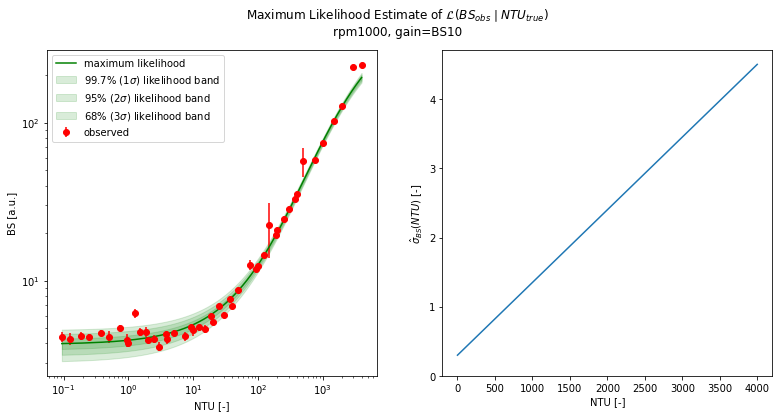

In [17]:
x_dense = numpy.arange(min(sorted(x_observed)), max(sorted(x_observed)), 0.1)

fig, axs = pyplot.subplots(nrows=1, ncols=2, figsize=(13,6))
fig.suptitle('Maximum Likelihood Estimate of $\mathcal{L}(BS_{obs} \mid NTU_{true})$' + f'\nrpm{key}, ' + f'gain={gain}')
left, right = axs

# plot data
left.errorbar(x_observed, y_observed, y_std, label='observed', color='red', fmt ='o')

# plot fit
p_mu, p_sigma = biomass_error_model.error_model(theta=result.x, y_hat=x_dense)
left.plot(x_dense, p_mu, label='maximum likelihood', color='green')

for s, percent in enumerate([99.7, 95, 68]):
    s = s + 1
    left.fill_between(x_dense,
        p_mu-s*p_sigma,
        p_mu+s*p_sigma,
        alpha=.15, color='green', label=f'{percent}% (${s}\sigma$) likelihood band')

left.legend(loc = 'upper left')
left.set_xlabel('NTU [-]')
left.set_xscale('log')
left.set_ylabel('BS [a.u.]')
left.set_yscale('log')


right.plot(x_dense, p_sigma)
right.set_ylim(0)
right.set_xlabel('NTU [-]')
right.set_ylabel('$\hat{\sigma}_{BS}(NTU)$ [-]')


pyplot.show()

### Transformation  from NTU to CDW
We assume that the true backscatter, the true turbidity and the true cell dry weight correlate linearly. Therefore, the slope at the inflection point of the logistic function in non-log space $S$ should be the slope of the calibration curve of CDW against BS $C$ multiplied by a scaling factor $\alpha$:

$S[\frac{BS}{NTU}] = \alpha[\frac{CDW}{NTU}] \cdot C[\frac{BS}{CDW}]$


In [18]:
# Determining S in BS/NTU (non-log space)
y_I_x = biomass_error_model.logistic(numpy.exp(result.x[0]), result.x[:4])
eps = numpy.exp(result.x[0])/100000
y_I_x_eps = biomass_error_model.logistic(numpy.exp(result.x[0])-eps, result.x[:4])
slope_S = (y_I_x-y_I_x_eps)/eps

# C is provided by previous experiments:
slope_C = 8.324

# Calculating the scaling factor alpha:
alpha = slope_S/slope_C

In [19]:
print(f'y_I_x_eps = {y_I_x_eps}')
print(f'y_I_x = {y_I_x}')
print(f'eps = {eps}')
print(f'slope_S = {slope_S}')
print(f'alpha = {alpha}')

y_I_x_eps = [44.36091761]
y_I_x = [44.36129199]
eps = 0.005268451991064222
slope_S = [0.07106179]
alpha = [0.00853698]


### Plot data calibrated to CDW

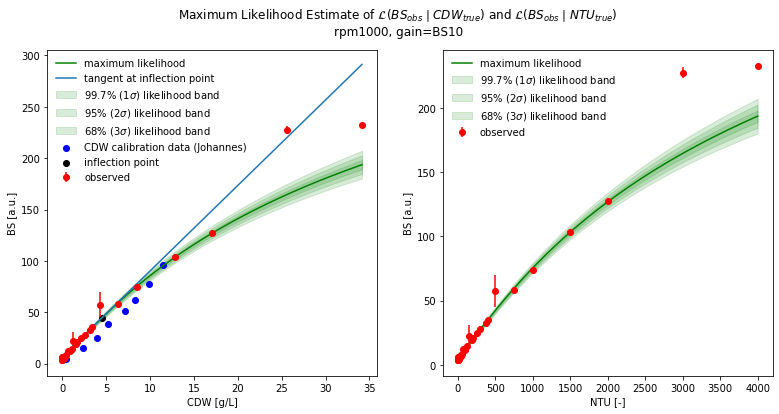

In [20]:
x_dense = numpy.arange(min(sorted(x_observed)), max(sorted(x_observed)), 0.1)
x_dense_CDW = alpha * x_dense
x_CDW = x_observed*alpha

fig, axs = pyplot.subplots(nrows=1, ncols=2, figsize=(13,6))
fig.suptitle('Maximum Likelihood Estimate of $\mathcal{L}(BS_{obs} \mid CDW_{true})$ and $\mathcal{L}(BS_{obs} \mid NTU_{true})$' + f'\nrpm{key}, '+ f'gain={gain}')
left, right = axs

## Plot against CDW
# Plot data
left.errorbar(x_CDW, y_observed, y_std, label='observed', color='red', fmt ='o')

# Plot fit
p_mu, p_sigma = biomass_error_model.error_model(theta=result.x, y_hat=x_dense)
left.plot(x_dense_CDW, p_mu, label='maximum likelihood', color='green')

for s, percent in enumerate([99.7, 95, 68]):
    s = s + 1
    left.fill_between(x_dense_CDW,
        p_mu-s*p_sigma,
        p_mu+s*p_sigma,
        alpha=.15, color='green', label=f'{percent}% (${s}\sigma$) likelihood band')

#Plot CDW calibration data and inflection point
x_cal_CDW = [0.486666667, 2.405, 3.961666667, 5.255, 7.11, 8.293333333, 9.901666667, 11.46333333]
y_cal_CDW = [4.956666667, 14.88666667, 25.45333333, 38.57, 51.70333333, 62.37333333, 77.89, 96.3]
left.scatter(x_cal_CDW, y_cal_CDW, label='CDW calibration data (Johannes)', color ='blue')
left.scatter(numpy.exp(result.x[0])*alpha, numpy.exp(result.x[1]), label = 'inflection point', color = 'black')

#Plot tangent line
tan = numpy.exp(result.x[1])+slope_C*(x_dense_CDW-numpy.exp(result.x[0])*alpha)
left.plot(x_dense_CDW, tan, label='tangent at inflection point')


left.legend(frameon = False, loc = 'upper left')
left.set_xlabel('CDW [g/L]')
#left.set_xscale('log')
left.set_ylabel('BS [a.u.]')
#left.set_yscale('log')



## Plot against NTU
# Plot data
right.errorbar(x_observed, y_observed, y_std, label='observed', color='red', fmt ='o')

# Plot fit
p_mu, p_sigma = biomass_error_model.error_model(theta=result.x, y_hat=x_dense)
right.plot(x_dense, p_mu, label='maximum likelihood', color='green')

for s, percent in enumerate([99.7, 95, 68]):
    s = s + 1
    right.fill_between(x_dense,
        p_mu-s*p_sigma,
        p_mu+s*p_sigma,
        alpha=.15, color='green', label=f'{percent}% (${s}\sigma$) likelihood band')

right.legend(frameon = False, loc = 'upper left')
right.set_xlabel('NTU [-]')
#right.set_xscale('log')
right.set_ylabel('BS [a.u.]')
#right.set_yscale('log')


pyplot.show()
